In [1]:
import numpy as np
import tensorflow as tf
import os, math, cv2, glob, random
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

train_dataset_path = './dataset/training'
validation_dataset_path  = './dataset/validation'

# width 550 height 367
IMAGE_HEIGHT  = 112
IMAGE_WIDTH   = 112
IMAGE_SIZE    = (IMAGE_HEIGHT, IMAGE_WIDTH)

CATEGORIES    = os.listdir(train_dataset_path)
NUM_CLASSES   = len(CATEGORIES)
BATCH_SIZE    = 8 
EPOCHS        = 60

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
def generate_data(path_data):
    dataset = []
    for category in CATEGORIES:
        path = f'{path_data}/{category}/'
        class_id = CATEGORIES.index(category)
        for image in os.listdir(path):
            try:
                image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_COLOR) 
                image_array = cv2.resize(image_array, (IMAGE_HEIGHT, IMAGE_WIDTH))  
                dataset.append([image_array, class_id])
            except Exception as e:
                print(e)
    random.shuffle(dataset)
    data = []
    labels = []
    for features, label in dataset:
        data.append(features)
        labels.append(label)
    data = np.array(data)
    data = data / 255.0
    return data, labels

train_data, train_label = generate_data(train_dataset_path)
data, labels = generate_data(validation_dataset_path)
validation_data, test_data, validation_label, _ = train_test_split(data, labels, test_size=0.15)

datagen_train = ImageDataGenerator(rescale=1.0/255.,
                                  rotation_range=35,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

datagen_test = ImageDataGenerator(rescale=1.0/255.,)
datagen_validation = ImageDataGenerator(rescale=1.0/255.,)

datagen_train.fit(train_data)
datagen_validation.fit(validation_data) 
datagen_test.fit(test_data)

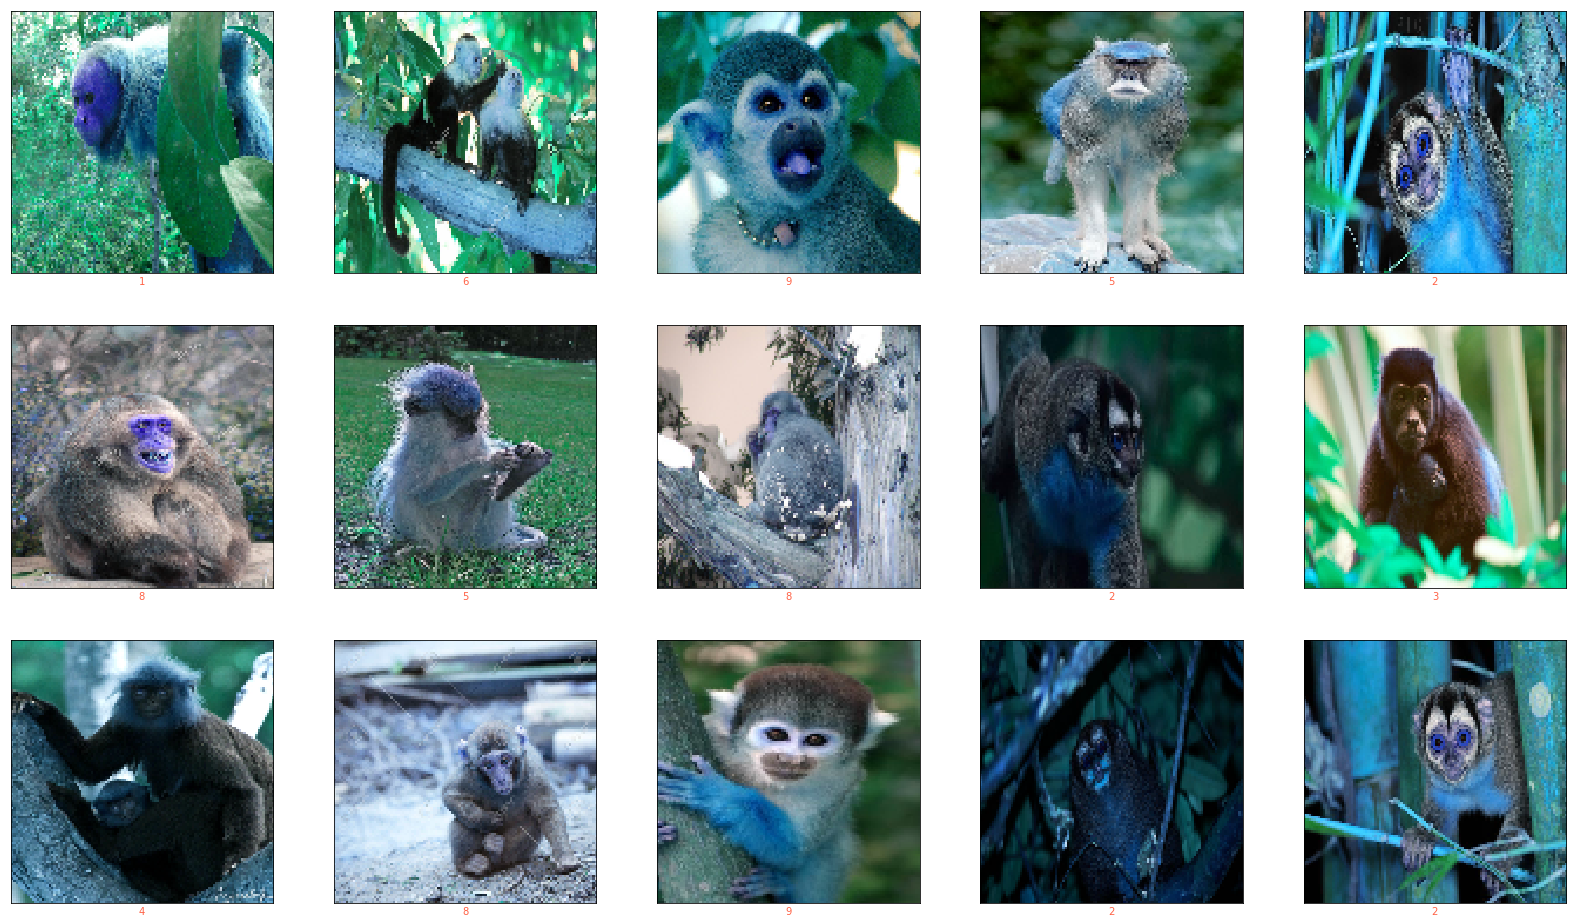

In [3]:
plt.figure(figsize=(IMAGE_HEIGHT/4, IMAGE_WIDTH/4))
i = 0
for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i])
    plt.xlabel(_[i], color='tomato')
    i += 1
plt.show()

In [4]:
def lr_decay(epoch):
    lr = 0.01 * math.pow(0.77, epoch);
    if lr <= 0.000001:
        return 0.000001
    else:
        return lr
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

callback_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, mode='auto', baseline=None, restore_best_weights=False)

tensorboard = tf.keras.callbacks.TensorBoard("logs")

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='loss',
                              mode='min',
                              factor=0.7,
                              patience=1,
                              min_lr=0.000001,
                              verbose=1)

In [5]:
l = tf.keras.layers
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y  = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = l.Input(shape=[IMAGE_WIDTH, IMAGE_HEIGHT, 3])
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum, axis=1)(x)
y = tf.keras.layers.Activation('relu')(y)

y = tf.keras.layers.Conv2D(kernel_size=3, filters=12, padding='same', activation='relu')(y)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)

y = fire_module(12, 24)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)


y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)

y = fire_module(12, 24)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)

y = tf.keras.layers.GlobalAveragePooling2D()(y)

y = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
model = tf.keras.Model(x, y)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 3)  448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 3)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 12) 336         activation[0][0]                 
______________________________________________________________________________________________

In [6]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs

In [7]:
from keras.utils import to_categorical
train_labels = to_categorical(train_label)
validation_labels = to_categorical(validation_label)

history = model.fit_generator(
    datagen_train.flow(train_data, train_labels, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_data) / BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=datagen_validation.flow(validation_data,     
    validation_labels, batch_size=BATCH_SIZE),
    callbacks=[tensorboard, reduce_learning_rate]) # callback_early_stop, lr_decay_callback  reduce_learning_rate,


Using TensorFlow backend.


Epoch 1/60
138/137 [==============================] - 11s 77ms/step - loss: 2.0981 - acc: 0.2368 - val_loss: 2.3245 - val_acc: 0.2684
Epoch 2/60
138/137 [==============================] - 5s 34ms/step - loss: 1.8382 - acc: 0.3279 - val_loss: 2.0035 - val_acc: 0.3333
Epoch 3/60
138/137 [==============================] - 5s 36ms/step - loss: 1.7047 - acc: 0.3552 - val_loss: 1.8920 - val_acc: 0.3723
Epoch 4/60
138/137 [==============================] - 5s 36ms/step - loss: 1.6385 - acc: 0.4016 - val_loss: 2.2363 - val_acc: 0.3030
Epoch 5/60
138/137 [==============================] - 5s 36ms/step - loss: 1.6046 - acc: 0.4089 - val_loss: 2.3626 - val_acc: 0.2251
Epoch 6/60
138/137 [==============================] - 5s 36ms/step - loss: 1.5378 - acc: 0.4199 - val_loss: 1.4626 - val_acc: 0.4719
Epoch 7/60
138/137 [==============================] - 5s 36ms/step - loss: 1.5084 - acc: 0.4435 - val_loss: 1.5507 - val_acc: 0.4416
Epoch 8/60
136/137 [============================>.] - ETA: 0s - loss

136/137 [============================>.] - ETA: 0s - loss: 0.7510 - acc: 0.7403
Epoch 00045: ReduceLROnPlateau reducing learning rate to 4.7475615428993474e-05.
138/137 [==============================] - 5s 35ms/step - loss: 0.7496 - acc: 0.7423 - val_loss: 0.7248 - val_acc: 0.7403
Epoch 46/60
136/137 [============================>.] - ETA: 0s - loss: 0.7576 - acc: 0.7338
Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.3232931309612467e-05.
138/137 [==============================] - 5s 35ms/step - loss: 0.7573 - acc: 0.7322 - val_loss: 0.7092 - val_acc: 0.7532
Epoch 47/60
136/137 [============================>.] - ETA: 0s - loss: 0.7571 - acc: 0.7366
Epoch 00047: ReduceLROnPlateau reducing learning rate to 2.3263052935362793e-05.
138/137 [==============================] - 5s 35ms/step - loss: 0.7540 - acc: 0.7368 - val_loss: 0.7096 - val_acc: 0.7100
Epoch 48/60
136/137 [============================>.] - ETA: 0s - loss: 0.7552 - acc: 0.7329
Epoch 00048: ReduceLROnPlateau redu

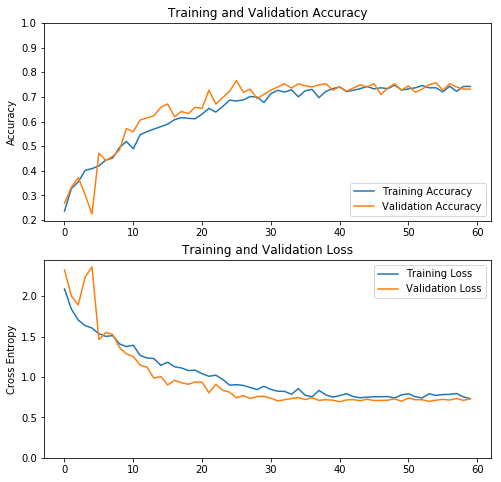

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()